# <center>Almgren-Chriss Optimal Execution Model</center>

The Almgren-Chriss model, also known as the Almgren-Chriss optimal execution model, is a mathematical model that describes the optimal strategy for executing a trade in a financial market. It was developed by Robert Almgren and Neil Chriss in the late 1990s.

Let us consider a quantity X to be liquidated in increments $n_1…n_k$ with $x_k$ quantity which remains to be liquidated. We want everything to be sold at t=T.

**<u>Permanent market impact</u>** :
Refers to the long-term change in the market price of an asset resulting from a trade. This is the portion of the market impact that persists even after the trade has been completed. Therefore, the "equilibrum price" of the asset is modified in a permanent way:

$$S_k=S_{k-1}+\sigma \sqrt{\tau} \epsilon_k -\tau g(n_k/\tau)$$

**<u>Temporary market impact</u>** :
Refers to the short-term change in the price of an asset that is caused by the presence of the trade in the market. This is the portion of the market impact that disappears once the trade has been completed. Temporary market impact is typically associated with the transaction costs (difference between the bid and the ask price):

$$\overline{S_k}=S_{k-1}-h(n_k/\tau)$$

**<u>Cost of Trading</u>** :

The result of the sell of the asset is :

$$\sum\limits_{k=1} ^{N}n_k\overline{S_k}=XS_0+\sum\limits_{k=1} ^{N}(\sigma \sqrt{\tau} \epsilon_k -\tau g(n_k/\tau))x_k -\sum\limits_{k=1} ^{N}n_k h(n_k/\tau)$$

$XS_0$ represents what we were hoping to gain if we didn't have other costs.  
We define the trading cost as : 
$$C=XS_0-\sum\limits_{k=1} ^{N}n_k \overline{S_k}$$

In the Almgren-Chriss model, both permanent and temporary market impact are taken into account when computing the optimal trade execution strategy. By minimizing both types of market impact, a trader can minimize the cost of executing a trade.
So we will look for strategies minimizing :

$$E[C]+\lambda V[C]$$

with:  

$$E(C)=\sum\limits _{k=1} ^{N}[\tau x_k g(\frac{n_k}{\tau})+n_k h(\frac{n_k}{\tau})]$$

$$V(C)=\sigma^2\sum\limits _{k=1} ^{N}\tau x_k^2$$

$$\lambda : \text{risk aversion parameter}$$    


**<u>Almgren and Chriss hypothesis</u> : Linear impact** : 

$$\sum\limits _{k=1} ^{N}\tau x_k g(\frac{n_k}{\tau})=\frac{1}{2}\gamma X^2-\frac{1}{2}\gamma \sum\limits _{k=1} ^{N} n_k^2 $$

$$n_k h(\frac{n_k}{\tau})=\xi \left|{n_k}\right|+\frac{\eta n_k^2}{\tau}$$     

So $$E[C]+\lambda V[C]=\frac{1}{2}\gamma X^2+\xi \sum\limits _{k=1} ^{N}\left| n_k \right|+\frac{\tilde{\eta}}{\tau}\sum\limits _{k=1} ^{N}n_k^2$$  

with : $\xi$ half of the bid-ask spread. 

**<u>Optimal Strategies</u>** :
$$x_k=\frac{\sinh(\kappa(T-k\tau))}{\sinh(\kappa T)}X$$  

with :

$$\tilde{\kappa}^2=\frac{\lambda\sigma^2}{\eta}$$ 

$$\kappa=\frac{\text{arcosh}(\frac{1}{2}\tilde{\kappa}^2 \tau^2 +1)}{\tau}$$


**<u>Other parameters</u>** :

$$\gamma=\frac{Spread}{0.1\times \text{Daily Volume}}$$

$$\eta=\frac{Spread}{0.01\times \text{Daily Volume}}$$

$$\tilde{\eta}=\eta-\frac{1}{2}\gamma \tau$$


In [201]:
import numpy as np
import matplotlib.pyplot as plt

#xk : quantity remaining to be liquidated
def x(k, kappa, T, tau, X):
    numerator = np.sinh(kappa*(T-(k*tau)))*X   
    denominator = np.sinh(kappa*T)
    return(numerator/denominator)

#nk : quantity already liquidated
def n(X,k,kappa,T,tau):
    return X-x(k, kappa, T, tau, X)
    
#mean
def E(df, N, tau, gamma, etatilde,X,kappa,T,e): #liquidity risk
    somme_nk2 = 0
    somme_nk=0
    for k in range (1,N):
        somme_nk2 = somme_nk2 + pow(n(X,k,kappa,T,tau),2)
        somme_nk=somme_nk+abs(n(X,k,kappa,T,tau))
    return 0.5*gamma*pow(X,2)+e*somme_nk+(etatilde*somme_nk2/tau)

#variance 
def V (var,tau,X,T,kappa): #market risk 
    somme = 0
    for k in range (1,N):
        somme = somme + pow(x(k, kappa, T, tau, X),2)
    return var*somme*tau


In [202]:
#main
#!pip install yfinance
import pandas as pd
import yfinance as yf
goog = yf.Ticker('RMS.PA')
df = goog.history(period='1mo')
display(df)

#Parameters
X=1000 #1000 #quantity to be liquidated
T = 21 #21 day : How many days to sell all the shares.
N = 21 #21 transaction
tau = T/N #one transaction each day
var=np.var(df['Close'])
ld=pow(10,-5)

dailyVolume = np.mean(df['Volume'])
dailySpread = np.mean(df['High'] - df['Low'])

#epsilon
e=dailySpread/2

#gamma k
gamma=dailySpread/(0.1*dailyVolume)

#eta
eta=dailySpread/(0.01*dailyVolume)
etatilde=eta-0.5*gamma*tau

#kappa
kappatilde = np.sqrt(ld * var/eta)
kappa=np.arccosh(0.5*kappatilde**2 *tau**2 + 1)/tau

#Variance Mean
Variance= V(var,tau,X,T,kappa)
Mean= E(df, N, tau, gamma, etatilde,X,kappa,T,e)

#Liquidation srategy 
def Liquidation(N,kappa,T,tau,X):
    xk=[]
    nk=[]
    for k in range (N+1):
        xk.append(x(k, kappa, T, tau, X))
        nk.append(n(X,k,kappa,T,tau))
    return xk,nk

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-06 00:00:00+01:00,1501.5,1517.5,1500.5,1517.5,57139,0.0,0.0
2022-12-07 00:00:00+01:00,1512.5,1525.0,1501.5,1516.5,56882,0.0,0.0
2022-12-08 00:00:00+01:00,1512.0,1526.5,1507.5,1517.5,46751,0.0,0.0
2022-12-09 00:00:00+01:00,1530.0,1540.0,1514.0,1528.5,56674,0.0,0.0
2022-12-12 00:00:00+01:00,1519.5,1540.0,1518.5,1536.0,57182,0.0,0.0
2022-12-13 00:00:00+01:00,1542.0,1585.5,1530.5,1562.0,82527,0.0,0.0
2022-12-14 00:00:00+01:00,1559.0,1580.5,1539.5,1578.0,65731,0.0,0.0
2022-12-15 00:00:00+01:00,1552.5,1556.0,1481.5,1499.0,99843,0.0,0.0
2022-12-16 00:00:00+01:00,1492.5,1494.0,1460.0,1486.5,147423,0.0,0.0


In [203]:
print("lambda : ",ld)
print("gamma : ",gamma)
print("etatilde : ",etatilde)
print("kappa: ",kappa)
print("Mean : ",Mean)
print("Variance : ",Variance)
print("epsilon : ",e)

lambda :  1e-05
gamma :  0.005773736617716014
etatilde :  0.05485049786830214
kappa:  0.532146056249336
Mean :  1285425.7985693868
Variance :  881590922.7283976
epsilon :  16.83695652173913


**<br><u>Liquidation Strategy : </u></br>**  

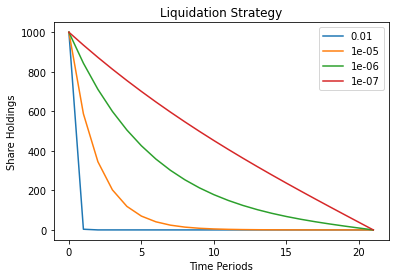

In [204]:
lambdas = [1e-2, 1e-5, 1e-6,1e-7]

for ld in lambdas:
    kappatilde = np.sqrt(ld * var/eta)
    kappa=np.arccosh(0.5*kappatilde**2 *tau**2 + 1)/tau
    t=np.linspace(0,T,N+1)
    xk,nk=Liquidation(N,kappa,T,tau,X)
    plt.plot(t,xk,label=ld)
plt.title(f"Liquidation Strategy")
plt.xlabel("Time Periods")
plt.ylabel("Share Holdings")
plt.legend() 
plt.show()

Start by Liquidating a large quantity then liquidate less and less
(fear of being exposed to market risk).

**<u>Remark</u>** :   
The solution depends on lambda which is specific to the trader and the market parameters.